In [1]:
import ROOT

Welcome to JupyROOT 6.11/01


### Mathematical Problem

A histogram of some distribution $y$ has $M$ bins. $\widehat \mu$ represents the ezpection value of the number of entries in bin $i$ of the histogram. So it progresses for the *true* histogram; $\mu_\mathrm{Tot}=\sum_i\mu_i$ and $p(y|i)=p_i=\mu_i/\mu_\mathrm{Tot}$ The goal of this problem is not to estimate the parameters $\theta$ that parametrise $f(y;\theta)$ but instead the $\mu_i$ parameters for each bin $\overline{\mu}=(\mu_1,...,\mu_M)$. This is not trivial because of fluctuations caused by the act of the measurement itself. Each observation is characterised by a unknown underlying value which is our function $y$ which we are interested in and a measured value $x$ obtained by the experiment.

$$
f(x)_\mathrm{meas}=\int R(x|y)f_\mathrm{true}(y)dy
$$

Where $R(x|y)$ is the response function if $x$ and $y$ are the pdfs represented by histograms. This can be done in RooUnfold as:

In [2]:
response = ROOT.RooUnfoldResponse (40, -10.0, 10.0)

In which the first term is the number of bins and the range over which you which this function to be valid over however the crux of the function needs a true histogram and a measured histogram to produce a response which can be drawn as a two dimensional histogram. Before we make one let's see how they're used!

first we make some function that smears some distribution and removes certain events to mimic the measurement efficiency.

In [3]:
def smear(xt):
  xeff = 0.3 + (1.0-0.3)/20*(xt+10.0)  #  efficiency                                                                                  
  x = ROOT.gRandom.Rndm()
  if x>xeff: return None
  xsmear = ROOT.gRandom.Gaus(-2.5,0.2)     #  bias and smear 
  return xt + xsmear

Train with a Breit-Wigner, mean 0.3 and width 2.5.     

In [4]:
for i in xrange(100000):
  xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  x = smear(xt)
  if x!=None:
    response.Fill(x, xt)
  else:
    response.Miss(xt)

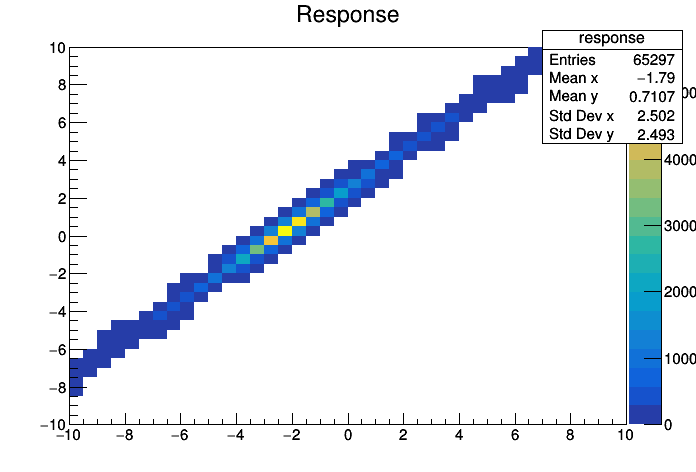

In [5]:
R = response.HresponseNoOverflow()
c1 = ROOT.TCanvas()
R.Draw("colz")
c1.Draw()

Ok so we need three histograms 2 are 1 dimensional and 1 is 2D. First of all we assume that both distributions have the same range and number of bins. We can add additional options for overloading etc. but for now this is fine. We need the distribution for both true and measured distributions (defined by fill) and also a case for if the measured event doesn't pass the efficiency criteria (called Miss).

In [6]:
class Response:
    def __init__(self, nb, xlo, xhi):
        self.measured = ROOT.TH1D("measured","measured",nb, xlo, xhi)
        self.truth = ROOT.TH1D("truth","truth",nb, xlo, xhi)
        self.response = ROOT.TH2D("Response","Response",nb, xlo, xhi, nb, xlo, xhi)
    def Fill(self, xr, xt):
        self.measured.Fill(xr)
        self.truth.Fill(xt)
        self.response.Fill(xr, xt)
    def Miss(self, xt):
        self.truth.Fill(xt)

And now lets fill it the same way!

In [7]:
new_response = Response(40, -10.0, 10.0)
for i in xrange(100000):
  xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
  x = smear(xt)
  if x!=None:
    new_response.Fill(x, xt)
  else:
    new_response.Miss(xt)

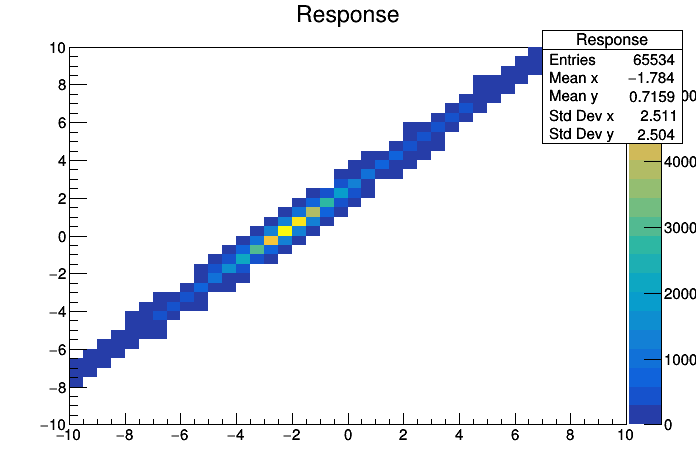

In [8]:
R = new_response.response
c1 = ROOT.TCanvas()
R.Draw("colz")
c1.Draw()

At this point we should also change from our $f_\mathrm{meas}(x)$ to a notation more suitable to histograms. 
$$
f(x)_\mathrm{meas}=\int R(x|y)f_\mathrm{true}(y)dy
$$
becomes
$$
\nu_i=\sum_{j=1}^M R_{ij}\mu_j,\ \ \ \ \ i= 1,...,N
$$
Where $\mu$ is once again the expectation values for the histogram of $y$ and $\nu$ is the expected number of events in the bins of the observed variable $x$. NB. True data will be an actual event count in each bin and therefore integer values whereas $\nu$ is typically non-integer values. 

We can understand the response matrix as the conditional probability. By summing over the observed data we get the efficiency $\epsilon_j$ for each bin of the true histogram.

We now have several ingreedients; $\nu,\mu$ and $R$. Since the data is a collection of integers $\mathbf{n}$ we can express the above equation as not only the expectation value per bin given the data but also to include the expected number of background events in that bin $\beta_i$. 

$$
E[\mathbf{n}]=\nu=R\mu+\beta
$$

<center> <h3> Interlude: Don't unfold if you can help it. </h3></center>

Unfolding allows for the preservation of the results of the experiment as it preserves a snapshot of the experimental response within its result. However this information is rarely actually preserved and therefore when errors are inevitably made, the mistakes might forever make the results of the experiment un-usable unless both the data and the response matrix are preserved. 

Anyway, moving on...

#### Unfolding? What's that?
By unfolding we construct estimators  $\widehat{\mu}$ for the bins of $y$ This is useful to directly compared with the results of other experiments as well as with theoretical predictions.


If our goal is generally $\mu$ then we need to invert our response matrix. 
$$
\boldsymbol{\mu}= R^{-1}(\boldsymbol{\nu}-\beta)
$$
We can assume the data is independent (individual events) and therefore each bin can be assumed to follow a poisson distribution.

$$
P(n_i;\nu_i)=\frac{\nu_u^{n_i}}{n_i\!}\exp^{-\nu_i}
$$

The maximum likelihood estimators for $\nu$ are $\mathbf{n}$ and thus can be taken as estimators for $\mu$,

$$
\boldsymbol{\widehat{\mu}}=R^{-1}(\mathbf{n}-\beta)
$$

In a perfect (exact) world all of the elements of the response matrix should be on the diagonal as large, off-diagonal elements indicate that the bin size is too small compared to the measurement resolution, then the estimates of $\ \boldsymbol{\widehat{\mu}}$ will have prohibatively large variances and will have strong negative correlations between neighbouring bins. It can be [prooved](http://www.ippp.dur.ac.uk/Workshops/02/statistics/proceedings/cowan.ps) that for independent poisson variables ML estimators in this case are unbiased. By calculating the minimum variance bound in this (unbiased) case we can assume that any estimators that we can construct that have a smaller variance will be biased in some way. This method can be understood as mittigating the effects of a large statistical error in favour of a smaller systematic error.

### Corrections from simulation

In high energy physics a simple method to construct estimators using simulations in order to produced estimators with smaller variances. This takes the form of a correction factor:

$$
\widehat{\mu}_i=\frac{\mu_i^\mathrm{MC}}{\nu_i^\mathrm{MC}}(n_i-\beta_i)
$$

Here the superscript $^\mathrm{MC}$ denotes values obtained from Monte Carlo simulation. Usually this is only done for the signal process since the background is subtracted separately. 

The covariance matrix for the process is given as:
$$
U_{ij}=\mathbf{cov}[\widehat{\mu}_i,\widehat{\mu}_j]=C_i^2\mathbf{cov}[n_i,n_j]
$$

If the correction factors are not too large (order of unity) the variances of the estimators do not become much larger than those provided by the poisson statistics of the data. These estimators are biased $b_i=E[\widehat{\mu}_i]-\mu_i\neq0$ but this bias can be calculated as:
$$
b_i = \left(\frac{\mu_i^\mathrm{MC}}{\nu_i^\mathrm{MC}}-\frac{\mu_i}{(\nu_i-\beta_i)}\right)(\nu_i-\beta_i)
$$

Since this bias is related to the correctness of the model the bias tends to pull the estimators towards the predictions of the MC that we used for making the correction factors. In general this is better estimated by directly comparing the data and the models predicted $\nu$ since use of this method requires including an estimate of the bias as a systematic uncertainty of the measurement. 

### Bayesian Unfolding

this is an iterative method proposed by [D'Agostini](http://inspirehep.net/record/374574?ln=en) based on the elements of Bayesian statistics. An initial set of probabilities are given as $p_i=1/M$ for bins of equal size and these are used to provide the initial estimators. 
$$
\boldsymbol{\widehat{\mu}}_0=n_{tot}\mathbf{p}_0
$$

These are updated using bayes theorem to write the conditional probability that the event originate in bin $i$ given that it was observed in bin $j$ using the response matrix $R$ and the prior probabilities $\mathbf{p}$:

$$
\boldsymbol{\widehat{\mu}}_i=\frac{1}{\epsilon_i}\sum_{j=1}^N P(\mathrm{\ true\ value\ in\ bin\ }i\ |\ \mathrm{found\ in\ bin\ }j\ )\ n_j
$$

$$
=\frac{1}{\epsilon_i}\sum_{j=1}^N\left(\frac{R_{ij}p_i}{\sum_kR_{jk}p_k}\right)
$$

These updated estimators are compared to those of the previous iteration by using a goodness of fit test such as the $\chi^2$ test and then repeated if necesarry. 

<center> <h3> Interlude: Not actually Bayesian. </h3></center>

The procedure uses Bayes’ theorem in an intermediate step however, calling it a Bayesian method implies that the estimators summarize in some way a joint posterior pdf for $\mu$, normaly that $p(\boldsymbol{\mu}|\mathbf{n})$ is related to the likelihood and the prior probability. Since this is not the case the *iterative* method is more descriptive... but less commonly used.  

anyway... moving on...

### Iterative code

Using the response matrix we trained earlier using a breit-wigner distribution. We can now test with a gaussian.

In [9]:
hTrue = ROOT.TH1D ("true", "Test Truth",    40, -10.0, 10.0);
hMeas = ROOT.TH1D ("meas", "Test Measured", 40, -10.0, 10.0);
#  Test with a Gaussian, mean 0 and width 2.                                                                                          
for i in xrange(10000):
    xt = ROOT.gRandom.Gaus (0.0, 2.0)
    x = smear (xt);
    hTrue.Fill(xt);
    if x != None: hMeas.Fill(x);

10000.0 6506.0


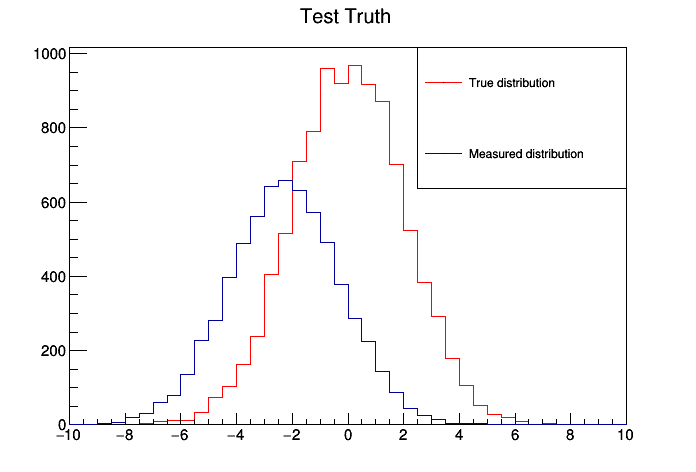

In [10]:
print hTrue.GetEntries(), hMeas.GetEntries()

c1 = ROOT.TCanvas()
hTrue.SetStats(0)
hTrue.SetLineColor(2)
hTrue.Draw()
hMeas.Draw("same")

leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrue, "True distribution","pl")
leg.AddEntry(hMeas, "Measured distribution", "pl")
leg.Draw()
c1.Draw()

And now we call the function that we want. Here we take the RooUnfoldBayes function which requires a response matrix and the measured histogram to produce an unfolded histogram. The final input is the number of iterations required in this iterative method.

In [11]:
unfold = ROOT.RooUnfoldBayes(response, hMeas, 4)
hReco = unfold.Hreco()

Now unfolding...
Iteration : 0
Chi^2 of change 959.777
Iteration : 1
Chi^2 of change 6.79945
Iteration : 2
Chi^2 of change 0.97303
Iteration : 3
Chi^2 of change 0.475124
Calculating covariances due to number of measured events


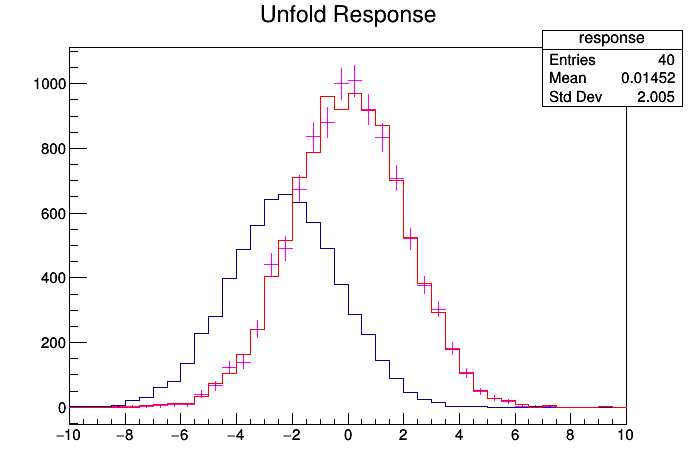

In [12]:
c1 = ROOT.TCanvas()
hReco.SetLineColor(6)
hReco.Draw()
hMeas.Draw("same")
hTrue.Draw("same")
c1.Draw()

So let's copy this function!

In [13]:
class UnfoldIterative:
    def __init__(self, response, measured, niterations):
        self.response = response
        self.measured = measured
        self.niterations = niterations
        self.unfolded = False
        self.nm = response.measured.GetNbinsX()
        self.nt = response.truth.GetNbinsX()

    def unfold(self):
        mu = ROOT.TVectorD(self.nt)
        p = ROOT.TVectorD(self.nt)
        ntot = self.measured.Integral()
        for i in range(self.nt):
            p[i] = 1./self.nt
            mu[i] = ntot/self.nt
            
        epsilons = ROOT.TVectorD(self.nt)
        self.reco = self.response.truth.Clone()
        response = self.response.response

        for j in range(self.nt):
            observed_anywhere = 0.0
            for i in range(self.nm):
                observed_anywhere += response.GetBinContent(i,j)
            epsilons[j] = observed_anywhere/self.response.truth.GetBinContent(j)

        for iteration in range(self.niterations):
            for i in range(1,self.nt+1):    # which bin in the reco distribution
                sumoverj = 0.0
                sumofmus = 0.0
                for j in range(1,self.nm+1):
                    sumoverk = 0.0
                    for k in range(1,self.nt+1):
                        sumoverk += response.GetBinContent(j,k)*p[k-1]
                    if sumoverk > 0: 
                        sumoverj += self.measured.GetBinContent(j)*response.GetBinContent(j,i)*p[i-1]/sumoverk
                    else: sumoverj += 0.0
                mu[i-1] = sumoverj/epsilons[i-1]
                

            mutot = 0.0
            for j in range(self.nt):
                mutot += mu[j]
            for j in range(self.nt):                
                p[j] = mu[j]/mutot

        for i in range(1,self.nt+1):
            self.reco.SetBinContent(i,mu[i-1])

    def Hreco(self):
        if self.unfolded: return self.reco
        else:
            self.unfold()
            return self.reco

In [14]:
new_unfold = UnfoldIterative(new_response, hMeas, 4)

In [15]:
new_reco = new_unfold.Hreco()

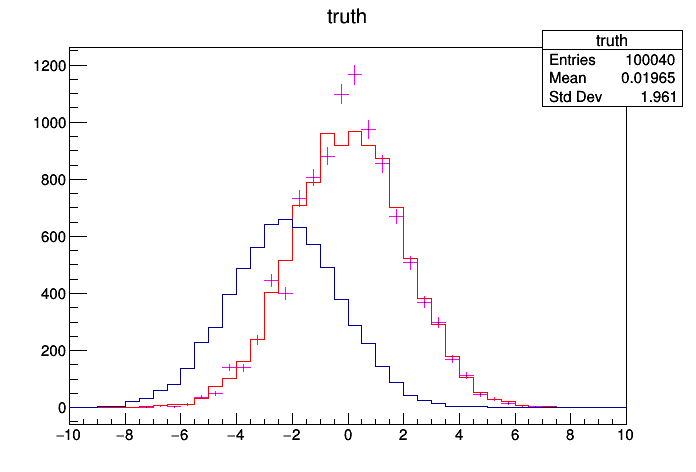

In [16]:
c1 = ROOT.TCanvas()
new_reco.SetLineColor(6)
new_reco.Draw("e0")
hTrue.Draw("same")
hMeas.Draw("same")
c1.Draw()